# Packages

##  For user networks

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import requests
import numpy as np
from pandas.io.json import json_normalize

# List of documents

In [0]:
FMlinkList = {
    'october2017':"http://educatorinnovator.org/how-young-activists-deploy-digital-tools-for-social-change",
    'november2017':"https://educatorinnovator.org/wp-content/uploads/2017/10/RRE_Chapter-6_Civic-Participation-Remiagined_0091732X17690121.pdf",
    'december2017':"https://educatorinnovator.org/wp-content/uploads/2017/10/Critical-Literacy-And-Our-Students-Lives.pdf",
    'january2018':"https://educatorinnovator.org/wp-content/uploads/2017/12/OurDeclaration_PG31-35.pdf",
    'february2018':"https://educatorinnovator.org/wp-content/uploads/2018/02/Educating-for-Democracy-in-a-Partisan-Age.pdf.pdf",
    'march2018':"https://educatorinnovator.org/wp-content/uploads/2018/02/The-Stories-They-Tell-.pdf",
    'april2018':"https://educatorinnovator.org/wp-content/uploads/2018/03/Educating-Youth-for-Online-Civic-and-Political-Dialogue_-A-Conceptual-Framework-for-the-Digital-Age-_-Journal-of-Digital-and-Media-Literacy.pdf",
    'may2018':"https://educatorinnovator.org/wp-content/uploads/2018/03/zemelman_websample.pdf",
    'june2018':"http://www.ncte.org/library/NCTEFiles/Resources/Journals/VM/0254-may2018/VM0254Leading.pdf"
}

# Helper functions


In [0]:
# Build dataframe from hypothes.is API
def H_API(session,uri):
    n = 0
    payload = {'url':uri}
    r = requests.get('https://hypothes.is/api/search',params=payload)
    tmp = pd.DataFrame(columns=['created', 'document.title', 'group', 'id', 'links.html',
       'links.incontext', 'links.json', 'permissions.admin',
       'permissions.delete', 'permissions.read', 'permissions.update',
       'references', 'tags', 'target', 'text', 'updated', 'uri', 'user'])
    total = r.json()['total']
    print(session)
    print(uri)
    print('Number of Records Found for this Session: ',total)
    print('Scraped:')
    while n < total:
        print(n)
        tmp = tmp.append(json_normalize(r.json()['rows']))
        n = len(tmp)
        payload = {
            'url':uri,
            'offset':n}
        r = requests.get('https://hypothes.is/api/search',params=payload)
    print(n)
    tmp['session'] = session
    tmp['updated'] = pd.to_datetime(tmp['updated'])
    tmp['created'] = pd.to_datetime(tmp['created'])
    tmp = tmp.set_index(tmp['created'])
    return tmp

#returns the number of times a message was in a reference list of other messages
def countReplies(msgId):
    return len(df.dropna()[df['references'].dropna().map(lambda x: msgId in x)])
def listOfIds(msgId):
    return df.dropna()[df['references'].dropna().map(lambda x: msgId in x)]['id'].values
def replyTimeDelta(x):
    if len(df[df['id']==x]['created']) == 0:
      return None
    else:
      return df[df['id']==x]['created'].iloc[0]
def replyToUser(ref):
  if (len(df[df['id']==ref]['user'])==0):
    return None
  else: 
    return df[df['id']==ref]['user'].iloc[0]

# Create dataFrames

## With hypothes.is data

In [0]:
df = pd.DataFrame(columns=['created','document.title','group','id','links.html',
       'links.incontext','links.json','permissions.admin',
       'permissions.delete','permissions.read','permissions.update',
       'references','tags','target','text','updated','uri','user','session'])
for session,link in FMlinkList.items():
    df = df.append(H_API(session,link))
df = df.tz_localize('UTC').tz_convert('US/Mountain')
# print('Total Records: ',len(df))

#Modify df for network analysis
df = df[['created','id','references','session','tags','target', 'text','user']]
df['user'] = df['user'].map(lambda x: x[5:-12])
df['replyTo'] = df['references'].map(lambda x: x[-1],na_action='ignore')
df['replyTo'].fillna('Doc',inplace=True)
df['replyToUser'] = df[df['replyTo'].notnull()]['replyTo'].map(lambda x: replyToUser(x))
for index, row in df.iterrows():
  if (row['replyTo']=='Doc'):
    df.loc[index, 'replyToUser'] = df.loc[index]['session']

#Time betweeen message and reply
df['replyDelay'] = df[df['replyTo'].notnull()]['created']\
- df[df['replyTo'].notnull()]['replyTo'].map(lambda x: replyTimeDelta(x))

#convert to minutes
df['replyDelay'] = df['replyDelay'].map(lambda x: x.total_seconds() / 60)

## Build network of threads (2 or more messages in conversation)

In [0]:
MG = nx.from_pandas_edgelist(df,'user','replyToUser'
                           ,edge_attr=['tags','text']
                           ,create_using=nx.MultiDiGraph())

G = DiGraph()
for (u,v) in MG.edges():
    G.add_edge(u, v, weight=len(MG[u][v]))

g = nx.Graph()
g.add_edges_from(G.edges(), weight=0)

for u, v, d in G.edges(data=True):
    g[u][v]['weight'] += d['weight']
    
nodeSize = nx.degree(g)
nodeSize = [(nodeSize[node]+1) * 20 for node in g.nodes()]

edges = g.edges()
weights = [g[u][v]['weight'] for u,v in edges]

NameError: ignored

## Displays 

### All users

In [0]:
from graphviz import Digraph

In [0]:
nx.nx_agraph.graphviz_layout(g)

ImportError: ignored

In [0]:
plt.figure(figsize=(10,10))
nx.drawing(g,prog='neato',with_labels=True,node_size=nodeSize)#,width=weights)
plt.show()

AttributeError: ignored

<Figure size 720x720 with 0 Axes>

###For a specific user

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


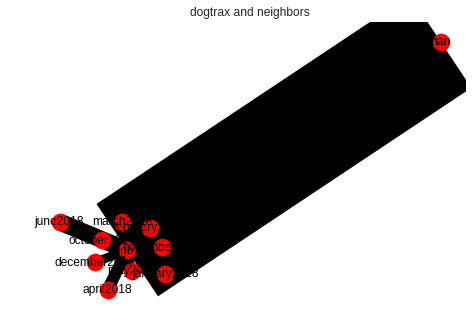

In [0]:
## change the user
## List of users ['stephanied42', 'Laika57', 'ifrank', 'hypervisible', 'actualham',
##       'billfitzgerald', 'clhendricksbc', 'jdamhof', 'bali', 'BMBOD',
##       'onewheeljoe', 'ndsteinmetz', 'remiholden', 'JenProf', 'kmriebau',
##       'bhwilkoff', 'jeremydean', 'DrYemiS', 'autumm393']

u = 'dogtrax'
sourceNodeNeighbors = [x for x in nx.all_neighbors(g,u)]
sourceNodeNeighbors.append(u)
edges = g.subgraph(sourceNodeNeighbors).edges()
weights = [g[u][v]['weight'] for u,v in edges]
nx.draw_kamada_kawai(g.subgraph(sourceNodeNeighbors),with_labels=True,width=weights)
plt.title(u+' and neighbors')
plt.show()

### Users and their neighbors

In [0]:
for uu in df[df['references'].notnull()]['user'].unique():
  sourceNodeNeighbors = [x for x in nx.all_neighbors(g,uu)]
  sourceNodeNeighbors.append(uu)
  nx.draw_kamada_kawai(g.subgraph(sourceNodeNeighbors),with_labels=True,width=weights)
  plt.title(uu+' and neighbors')
  plt.show()